In [12]:
import numpy as np
import pandas as pd

In [13]:
df_weekday = pd.read_csv('../../data/bike_rental_history/processed_30min_aggregated/2023_processed_weekday_agg.csv')

# create undirected route for the newman method
df_weekday.loc[:,'route_undirect'] = df_weekday.loc[:,['origin_station_id', 'desti_station_id']].apply(lambda x: f'{sorted(x)[0]}~{sorted(x)[1]}', axis=1)
df_weekday_undirected = df_weekday.groupby('route_undirect').agg({'count':'sum'}).reset_index()
df_weekday_undirected.loc[:,'origin_id'] = df_weekday_undirected.loc[:,'route_undirect'].apply(lambda x: x.split('~')[0])
df_weekday_undirected.loc[:,'desti_id'] = df_weekday_undirected.loc[:,'route_undirect'].apply(lambda x: x.split('~')[1])
df_weekday_undirected = df_weekday_undirected.drop(columns=['route_undirect'])

## the travel between same station is not considered    
df_weekday_undirected = df_weekday_undirected.loc[df_weekday_undirected.loc[:,'origin_id'] != df_weekday_undirected.loc[:,'desti_id']]
df_weekday_undirected

,count,origin_id,desti_id
1,7,ST-1000,ST-1005
2,6,ST-1000,ST-1523
3,6,ST-1000,ST-1731
4,3,ST-1000,ST-1964
5,21,ST-1000,ST-1996
...,...,...,...
30563,57,ST-988,ST-99
30565,6,ST-98,ST-984
30566,33,ST-98,ST-987
30567,67,ST-98,ST-99


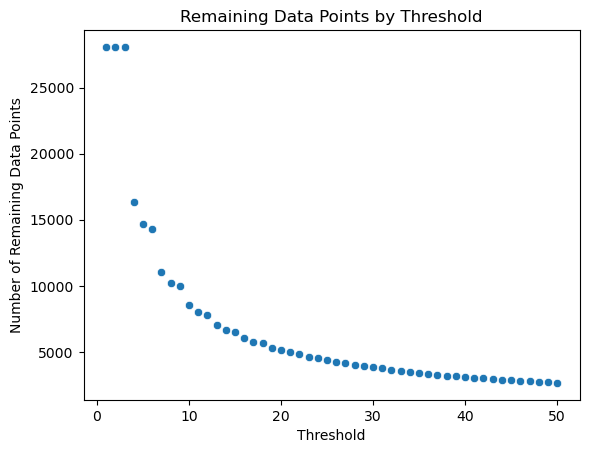

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

thresholds = range(1, 51)
remaining_data = []

for threshold in thresholds:
    filtered_df = df_weekday_undirected[df_weekday_undirected['count'] >= threshold]
    remaining_data.append(len(filtered_df))

sns.scatterplot(x=thresholds, y=remaining_data)
plt.xlabel('Threshold')
plt.ylabel('Number of Remaining Data Points')
plt.title('Remaining Data Points by Threshold')
plt.show()

In [15]:
import networkx as nx
from networkx.algorithms.community import louvain_partitions

G = nx.from_pandas_edgelist(df_weekday_undirected.loc[df_weekday_undirected.loc[:,'count']>6], source='origin_id', target='desti_id', edge_attr='count')
partition = list(louvain_partitions(G, weight='count', resolution=1))


Community 1: 76 stations
Community 2: 44 stations
Community 3: 29 stations
Community 4: 53 stations
Community 5: 2 stations
Community 6: 53 stations
Community 7: 82 stations
Community 8: 130 stations
Community 9: 117 stations
Community 10: 54 stations
Community 11: 10 stations
Community 12: 103 stations
Community 13: 98 stations
Community 14: 85 stations
Community 15: 175 stations
Community 16: 38 stations
Community 17: 120 stations
Community 18: 18 stations
Community 19: 80 stations
Community 20: 68 stations
Community 21: 84 stations
Community 22: 59 stations
Community 23: 98 stations
Community 24: 40 stations
Community 25: 29 stations
Community 26: 77 stations
Community 27: 2 stations
Community 28: 66 stations
Community 29: 92 stations
Community 30: 82 stations
Community 31: 151 stations
Community 32: 2 stations
Community 33: 9 stations
Community 34: 3 stations
Community 35: 175 stations
Community 36: 3 stations
Community 37: 2 stations
Community 38: 2 stations
Community 39: 2 statio

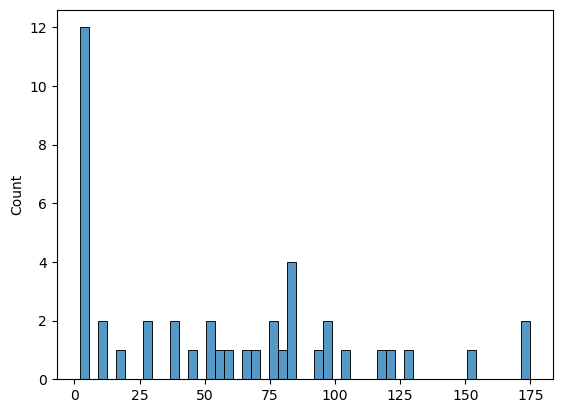

In [16]:
for i, c in enumerate(partition[2]):
    print(f'Community {i+1}: {len(c)} stations')

# draw histogram of community size
community_sizes = [len(c) for c in partition[2]]
sns.histplot(community_sizes, bins=50)

# sort the community by edge count
def community_edge_count(c):
    edge_count = 0
    for i in range(len(c)):
        for j in range(i+1, len(c)):
            if G.has_edge(c[i], c[j]):
                edge_count += G[c[i]][c[j]]['count']
    return edge_count

sorted_partition = sorted([list(c) for c in partition[2]], key=community_edge_count, reverse=True)

In [17]:
for i, c in enumerate(sorted_partition):
    print(f'Community {i+1}: {len(c)} stations, {community_edge_count(c)} edges')

Community 1: 117 stations, 235110 edges
Community 2: 76 stations, 78360 edges
Community 3: 66 stations, 64611 edges
Community 4: 82 stations, 58950 edges
Community 5: 53 stations, 55639 edges
Community 6: 175 stations, 53314 edges
Community 7: 103 stations, 52816 edges
Community 8: 82 stations, 52697 edges
Community 9: 59 stations, 46905 edges
Community 10: 98 stations, 44795 edges
Community 11: 130 stations, 42151 edges
Community 12: 68 stations, 40221 edges
Community 13: 151 stations, 40183 edges
Community 14: 54 stations, 38027 edges
Community 15: 38 stations, 30273 edges
Community 16: 175 stations, 30173 edges
Community 17: 40 stations, 25540 edges
Community 18: 85 stations, 20838 edges
Community 19: 98 stations, 18809 edges
Community 20: 84 stations, 18736 edges
Community 21: 77 stations, 18575 edges
Community 22: 53 stations, 17919 edges
Community 23: 92 stations, 13560 edges
Community 24: 120 stations, 11883 edges
Community 25: 44 stations, 11753 edges
Community 26: 80 stations,

In [18]:
df_weekday

,rent_datetime_30min,origin_station_id,desti_station_id,count,route_undirect
0,2023-01-02 00:00:00,ST-3013,ST-670,4,ST-3013~ST-670
1,2023-01-02 00:00:00,ST-611,ST-1118,3,ST-1118~ST-611
2,2023-01-02 00:00:00,ST-753,ST-923,4,ST-753~ST-923
3,2023-01-02 00:30:00,ST-3153,ST-1729,3,ST-1729~ST-3153
4,2023-01-02 00:30:00,ST-32,ST-2975,3,ST-2975~ST-32
...,...,...,...,...,...
387480,2023-12-29 23:00:00,ST-541,ST-3070,3,ST-3070~ST-541
387481,2023-12-29 23:00:00,ST-702,ST-2851,3,ST-2851~ST-702
387482,2023-12-29 23:00:00,ST-914,ST-2070,3,ST-2070~ST-914
387483,2023-12-29 23:00:00,ST-919,ST-873,3,ST-873~ST-919


In [19]:
for i, c in enumerate(sorted_partition[:10]):
    df_weekday_tmp = df_weekday.drop('route_undirect', axis=1).loc[df_weekday.loc[:,'origin_station_id'].isin(c), :]
    df_weekday_tmp = df_weekday_tmp.loc[df_weekday_tmp.loc[:,'desti_station_id'].isin(c), :]
    df_weekday_tmp.to_csv(f'../../data/bike_rental_history/communities/weekday/{i}.csv', index=False)

## Weekend

In [20]:
df_weekend = pd.read_csv('../../data/bike_rental_history/processed_30min_aggregated/2023_processed_weekend_agg.csv')

# create undirected route for the newman method
df_weekend.loc[:,'route_undirect'] = df_weekend.loc[:,['origin_station_id', 'desti_station_id']].apply(lambda x: f'{sorted(x)[0]}~{sorted(x)[1]}', axis=1)
df_weekend_undirected = df_weekend.groupby('route_undirect').agg({'count':'sum'}).reset_index()
df_weekend_undirected.loc[:,'origin_id'] = df_weekend_undirected.loc[:,'route_undirect'].apply(lambda x: x.split('~')[0])
df_weekend_undirected.loc[:,'desti_id'] = df_weekend_undirected.loc[:,'route_undirect'].apply(lambda x: x.split('~')[1])
df_weekend_undirected = df_weekend_undirected.drop(columns=['route_undirect'])

## the travel between same station is not considered    
df_weekend_undirected = df_weekend_undirected.loc[df_weekend_undirected.loc[:,'origin_id'] != df_weekend_undirected.loc[:,'desti_id']]
df_weekend_undirected

,count,origin_id,desti_id
1,3,ST-1000,ST-1002
2,11,ST-1000,ST-1005
3,3,ST-1000,ST-1350
4,3,ST-1000,ST-1731
5,10,ST-1000,ST-1995
...,...,...,...
25095,17,ST-987,ST-99
25097,31,ST-988,ST-99
25099,3,ST-98,ST-987
25100,46,ST-98,ST-99


In [21]:
import networkx as nx
from networkx.algorithms.community import louvain_partitions

G = nx.from_pandas_edgelist(df_weekend_undirected.loc[df_weekend_undirected.loc[:,'count']>6], source='origin_id', target='desti_id', edge_attr='count')
partition = list(louvain_partitions(G, weight='count', resolution=1))

# sort the community by edge count
def community_edge_count(c):
    edge_count = 0
    for i in range(len(c)):
        for j in range(i+1, len(c)):
            if G.has_edge(c[i], c[j]):
                edge_count += G[c[i]][c[j]]['count']
    return edge_count

sorted_partition = sorted([list(c) for c in partition[2]], key=community_edge_count, reverse=True)

for i, c in enumerate(sorted_partition[:10]):
    df_weekend_tmp = df_weekend.drop('route_undirect', axis=1).loc[df_weekend.loc[:,'origin_station_id'].isin(c), :]
    df_weekend_tmp = df_weekend_tmp.loc[df_weekend_tmp.loc[:,'desti_station_id'].isin(c), :]
    df_weekend_tmp.to_csv(f'../../data/bike_rental_history/communities/weekend/{i}.csv', index=False)

In [22]:
for i, c in enumerate(sorted_partition):
    print(f'Community {i+1}: {len(c)} stations, {community_edge_count(c)} edges')

Community 1: 158 stations, 25863 edges
Community 2: 119 stations, 18936 edges
Community 3: 125 stations, 16569 edges
Community 4: 101 stations, 15773 edges
Community 5: 164 stations, 15140 edges
Community 6: 105 stations, 13689 edges
Community 7: 76 stations, 10769 edges
Community 8: 104 stations, 9758 edges
Community 9: 135 stations, 9505 edges
Community 10: 100 stations, 8419 edges
Community 11: 195 stations, 8388 edges
Community 12: 52 stations, 7495 edges
Community 13: 117 stations, 7379 edges
Community 14: 42 stations, 4031 edges
Community 15: 89 stations, 3515 edges
Community 16: 81 stations, 3164 edges
Community 17: 44 stations, 2696 edges
Community 18: 23 stations, 1271 edges
Community 19: 42 stations, 1116 edges
Community 20: 54 stations, 1047 edges
Community 21: 26 stations, 890 edges
Community 22: 13 stations, 600 edges
Community 23: 12 stations, 294 edges
Community 24: 6 stations, 146 edges
Community 25: 5 stations, 50 edges
Community 26: 6 stations, 43 edges
Community 27: 